In [ ]:
# Improting required dependencies
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Downloading dataset from Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace chest_xray/__MACOSX/chest_xray/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#**Dataset**
The Chest X-Ray Images (Pneumonia) dataset from Kaggle is a collection of 5,863 chest X-ray images in JPEG format organized into three folders (train, test, val) and two categories (Pneumonia/Normal).
The X-rays were selected from pediatric patients aged one to five years old who received chest X-rays as part of their routine clinical care at the Guangzhou Women and Children's Medical Center in Guangzhou. The images were screened for quality control, and diagnoses were graded by two expert physicians and checked by a third expert to account for any grading errors.
The dataset is designed to be used for developing AI systems to assist in the diagnosis of pneumonia, with the aim of improving patient outcomes.
The X-ray images show clear lungs without abnormal opacification for the Normal category, while the Pneumonia category displays either a focal lobar consolidation for bacterial pneumonia or a diffuse 'interstitial' pattern in both lungs for viral pneumonia.
# References:
1. https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
2. https://complexity.cecs.ucf.edu/chest-x-ray-images-pneumonia/
3. https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [ ]:
# Defining custom DataLoader
class ChestImageDataset(Dataset):
    def __init__(self, data, transform=None):

        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, label = self.data[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Defining the image augmentations to be made
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
# Loading the dataset
data_path = "/content/chest_xray"
train_normal = os.path.join(data_path, "train/NORMAL")
train_pneumonia = os.path.join(data_path, "train/PNEUMONIA")
test_normal = os.path.join(data_path, "test/NORMAL")
test_pneumonia = os.path.join(data_path, "test/PNEUMONIA")

train_normal_files = [os.path.join(train_normal, f) for f in os.listdir(train_normal) if f.endswith('.jpeg')]
train_pneumonia_files = [os.path.join(train_pneumonia, f) for f in os.listdir(train_pneumonia) if f.endswith('.jpeg')]
test_normal_files = [os.path.join(test_normal, f) for f in os.listdir(test_normal) if f.endswith('.jpeg')]
test_pneumonia_files = [os.path.join(test_pneumonia, f) for f in os.listdir(test_pneumonia) if f.endswith('.jpeg')]

train_files = train_normal_files + train_pneumonia_files
train_labels = [0] * len(train_normal_files) + [1] * len(train_pneumonia_files)
train_data = list(zip(train_files, train_labels))

test_files = test_normal_files + test_pneumonia_files
test_labels = [0] * len(test_normal_files) + [1] * len(test_pneumonia_files)
test_data = list(zip(test_files, test_labels))

train_dataset = ChestImageDataset(train_data, transform=train_transform)
test_dataset = ChestImageDataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


In [ ]:
# Defining model architecture inspired by the ResNet model
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        shortcut = self.shortcut(x)
        out += shortcut
        out = self.relu(out)

        return out

In [ ]:
# Combining multiple BasicBlock instances to form the complete network and final model ZubinRNet().
class ZubinRNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ZubinRNet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

# **Model Architecture:**
The model I have chosen to implement is ZubinRNet() model inspired by the ResNet model  which was proposed in Deep Residual Learning for Image Recognition by Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun. [1]
The ResNet model is a good deep learning model for the classification of Pneumonia vs Normal in the Chest X-Ray Images dataset due to its ability to train very deep neural networks with minimal degradation of performance. The ResNet architecture was specifically designed to address the problem of vanishing gradients that can occur in very deep neural networks. The architecture introduces a "skip connection" that allows gradients to be propagated more easily through the network, thus enabling the training of deeper networks.[2,3] ResNet has shown exceptional performance in various image classification tasks, including the ImageNet Large Scale Visual Recognition Challenge (ILSVRC), where it achieved top-5 error rates as low as 3.57%.[4]

# Implementation:
1. The BasicBlock class represents the fundamental building block of the ResNet architecture. It defines a single residual block containing two convolutional layers with Batch Normalization and ReLU activation functions, followed by a residual (skip) connection. The residual connection enables the network to learn the residual function, which is the difference between the input and the output of the block. This design helps to tackle the vanishing gradient problem and allows for more efficient training of deeper networks.
2. The ZubinRNet() combines multiple BasicBlock instances to form the complete network. This class defines the initial convolutional layer, the residual blocks organized in layers, and the final fully connected layer for classification. It also takes care of the forward pass through the entire network, ensuring that the residual connections are properly added to the outputs of their respective blocks.

# References:
1. https://huggingface.co/docs/transformers/model_doc/resnet
2. https://www.mygreatlearning.com/blog/resnet/#:~:text=Using%20ResNet%20has%20significantly%20enhanced,as%20compared%20to%20plain%2D34.
3. https://iq.opengenus.org/residual-neural-networks/
4. https://towardsdatascience.com/review-resnet-winner-of-ilsvrc-2015-image-classification-localization-detection-e39402bfa5d8


In [ ]:
# Initializing all arguaments and rpoviding model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ZubinRNet(BasicBlock, [2, 2, 2, 2]).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
# Defining training and testing loop
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss = running_loss / (batch_idx + 1)
    train_acc = 100. * correct / total

    return train_loss, train_acc


def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_acc = 100. * correct / total

    return test_acc






In [ ]:
# Code to clear GPU memory when debugging
torch.cuda.empty_cache()

In [ ]:
# Training the model
num_iter=30
train_loss_list, train_acc_list = [], []
test_acc_list= []

for epoch in range(num_iter):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_epoch_loss, train_epoch_acc = train(model, device, train_loader, loss_fn, optimizer, epoch)
    test_epoch_acc = test(model, device, test_loader)
    print(f"Train Error: \n Accuracy: {(train_epoch_acc):>0.2f}%, Avg loss: { train_epoch_loss:>8f} \n")
    print(f"Test: \n Accuracy: {(test_epoch_acc):>0.2f}%")

    scheduler.step()

    train_loss_list.append(train_epoch_loss)
    train_acc_list.append(train_epoch_acc)
    test_acc_list.append(test_epoch_acc)

print("Done!")

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 83.40%, Avg loss: 0.340509 

Test: 
 Accuracy: 66.03%
Epoch 2
-------------------------------
Train Error: 
 Accuracy: 92.14%, Avg loss: 0.200945 

Test: 
 Accuracy: 73.40%
Epoch 3
-------------------------------
Train Error: 
 Accuracy: 94.04%, Avg loss: 0.162115 

Test: 
 Accuracy: 68.11%
Epoch 4
-------------------------------
Train Error: 
 Accuracy: 94.71%, Avg loss: 0.149041 

Test: 
 Accuracy: 84.46%
Epoch 5
-------------------------------
Train Error: 
 Accuracy: 94.65%, Avg loss: 0.142224 

Test: 
 Accuracy: 70.03%
Epoch 6
-------------------------------
Train Error: 
 Accuracy: 95.42%, Avg loss: 0.119089 

Test: 
 Accuracy: 71.31%
Epoch 7
-------------------------------
Train Error: 
 Accuracy: 95.72%, Avg loss: 0.115124 

Test: 
 Accuracy: 86.54%
Epoch 8
-------------------------------
Train Error: 
 Accuracy: 96.18%, Avg loss: 0.102744 

Test: 
 Accuracy: 83.33%
Epoch 9
-------------------------------
Train Er

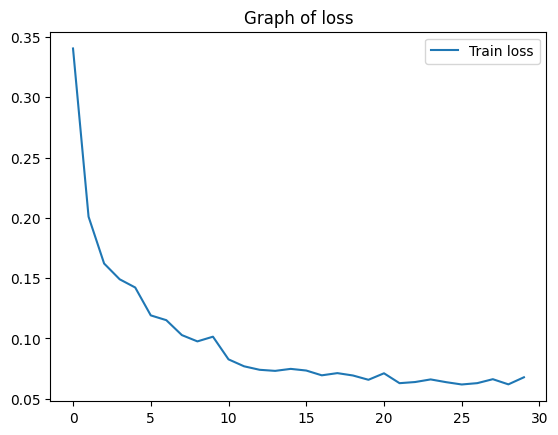

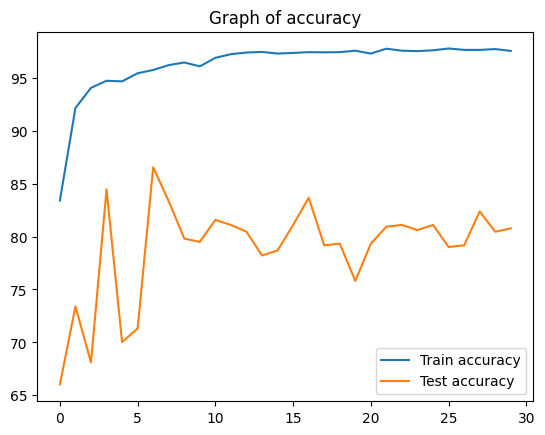

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Test Error: 
 Accuracy: 80.76923076923077


In [ ]:
# Plotting the results
plt.plot(train_loss_list, label='Train loss')
plt.title('Graph of loss')
plt.legend()
plt.show()

plt.plot(train_acc_list, label='Train accuracy')
plt.plot(test_acc_list, label='Test accuracy')
plt.title('Graph of accuracy')
plt.legend()
plt.show()

# Final test accuracy
test_acc_final = test(model, device, test_loader)
print("Final Test Error: \n Accuracy:", test_acc_final)